In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit.aqua.components.optimizers import SLSQP, COBYLA 

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import QNSPSA
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit.algorithms.optimizers import ADAM

from qiskit.quantum_info import Statevector

# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


In [2]:
def rand_numb(low_in,high_in):
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

#just to keep the upper limit included in the random number generation. 

In [3]:
def append(list1, list2):
    temp = []
    temp.extend(list1)
    temp.extend(list2)
    return temp

In [4]:
def createActual(x, L):
    temp = []
    for i in range(L):
        temp = np.append(temp, x)
    return temp

In [13]:
numLayer = 2
numQubit = 1

In [14]:
#Create unitaries here
unitary_param_1 = np.array([])
#for i in range(0, 8):
#    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))
 
unitary_param_1 = [1.86051851, 3.72215261, 1.57043552, 5.48869762, 
                   2.30980358, 5.01476937, 0.5581273, 3.88907588]

In [15]:
# First unitary
size = 2
layers = 2
qc1 = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        qc1.rx(unitary_param_1[j*size*2 + i], i)
        qc1.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        qc1.cx(i, i+1)

qc1.draw()

┌────────────┐┌────────────┐     ┌────────────┐┌─────────────┐     
q_0: ┤ Rx(1.8605) ├┤ Ry(1.5704) ├──■──┤ Rx(2.3098) ├┤ Ry(0.55813) ├──■──
     ├────────────┤├────────────┤┌─┴─┐├────────────┤└┬────────────┤┌─┴─┐
q_1: ┤ Rx(3.7222) ├┤ Ry(5.4887) ├┤ X ├┤ Rx(5.0148) ├─┤ Ry(3.8891) ├┤ X ├
     └────────────┘└────────────┘└───┘└────────────┘ └────────────┘└───┘

In [22]:
def createProver(numQubit, numLayer):
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

In [16]:
def createQuantumCircuit(numQubits, numLayer):
    circ = QuantumCircuit(8)
    #Create Quantum Circuit here
    return circ

In [17]:
qCirc = createQuantumCircuit(2, 2)

In [18]:
backend = Aer.get_backend('statevector_simulator')
q_instance = QuantumInstance(backend, shots = 8192, seed_simulator = 2718, seed_transpiler = 2718)
sampler = CircuitSampler(q_instance)

In [19]:
#Create Hamiltonian here
hamiltonian = I^I^I^I^I^I^MatrixOp(np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]))

In [20]:
def costf(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    result = sampler.convert(expectation, params=value_dict).eval()  
    return np.real(result)

In [21]:
def gradient(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    result = sampler.convert(gradient, params=value_dict).eval()
    return np.real(result)

In [23]:
print(qCirc.parameters)

ParameterView([])


In [24]:
loss = []

def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    loss.append(fx)
    if (nfev % 30 == 0):
        print("Loss Value : ", fx, str(nfev/3)+"%")

In [28]:
loss = []
numParam = numQubit*numLayer

paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))

print("Initial Cost : ", costf(paramProver))

#print("Gradient Vector")
#grad_vec = gradient(param)
#for i in range(numParam):
#    print(qCirc.parameters[i], grad_vec[i])

Initial Cost :  1.0


In [29]:
autospsa = SPSA(maxiter=100, learning_rate=0.5, perturbation=0.05, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, gradient_function=gradient, initial_point=paramProver)

Loss Value :  1.0 10.0%
Loss Value :  1.0 20.0%
Loss Value :  1.0 30.0%
Loss Value :  1.0 40.0%
Loss Value :  1.0 50.0%
Loss Value :  1.0 60.0%
Loss Value :  1.0 70.0%
Loss Value :  1.0 80.0%
Loss Value :  1.0 90.0%
Loss Value :  1.0 100.0%


In [30]:
print(paramProver)

[2.75800396 1.07244883 5.26633928 5.55370613]


<Figure size 1200x600 with 0 Axes>

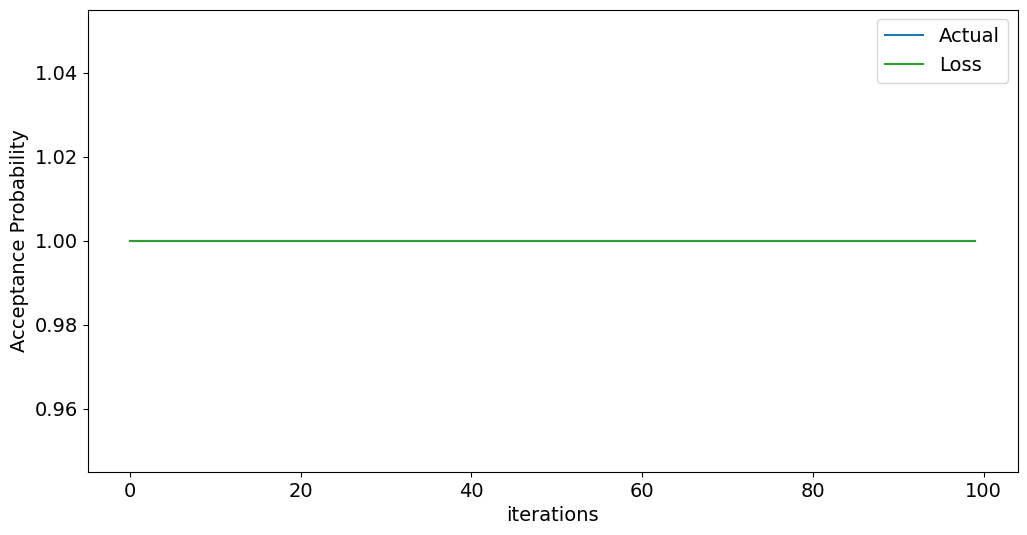

In [36]:
def plot_loss():
    start_point = 0
    plt.figure(figsize=(12, 6))
    plt.plot(createActual(1.0, len(loss[start_point:])), label = 'Actual')
    plt.plot(loss[start_point:], 'tab:green', label='Loss')
    plt.ylabel('Acceptance Probability')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()
plot_loss()